In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

# -------------------------------------
# 2. CONFIGURACIÓN
# -------------------------------------

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11715441639223892151
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4133486592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1725557201803639109
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:26:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
mixed_precision.set_global_policy('mixed_float16')

# Parámetros
img_size = (224, 224)
batch_size = 32
epochs = 100
seed = 123
train_dir = '../dataset/multi-6/train'
model_path = 'efficientnetb0_v2.keras'

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


# -------------------------------------
# 3. DATA AUGMENTATION Y GENERADORES
# -------------------------------------

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
# Obtener número de clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)


Found 30901 files belonging to 6 classes.
Using 24721 files for training.
Found 30901 files belonging to 6 classes.
Using 6180 files for validation.
Clases: ['Acne', 'Benign', 'Eczema', 'Infectious', 'Malign', 'Pigmentation']


In [6]:

# ---------------------------------------
# CÁLCULO DE PESOS POR CLASE
# ---------------------------------------
from sklearn.utils.class_weight import compute_class_weight

# Contar imágenes por clase
image_counts = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    image_counts.append(count)

# Crear vector de etiquetas reales
y_train = []
for i, count in enumerate(image_counts):
    y_train += [i] * count
y_train = np.array(y_train)

# Calcular pesos
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(weights))

print("Pesos por clase:", class_weight)

Pesos por clase: {0: 2.396618582286335, 1: 0.4733762254901961, 2: 1.2654381654381655, 3: 0.8583888888888889, 4: 0.7593002113125952, 5: 5.049346405228758}


In [7]:
# Optimización de rendimiento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Configuración de caché y prefetch
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [8]:
# Modelo base (preentrenado)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # congelamos capas base

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# Modelo completo (sin preprocessing dentro)
model = models.Sequential([
    base_model,
    data_augmentation,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

# Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight 
)


Epoch 1/100


C:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/sequential/random_rotation/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/sequential/random_rotation/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 7, 7, 1280), dtype=float16), dense_shape=Tensor("gradient_tape/sequential_1/sequential/random_rotation/loop_body/GatherV2/pfor/Cast:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


773/773 [==============================] - 218s 271ms/step - loss: 0.9227 - accuracy: 0.6316 - val_loss: 0.7442 - val_accuracy: 0.7013
Epoch 2/100
773/773 [==============================] - 204s 264ms/step - loss: 0.7478 - accuracy: 0.6992 - val_loss: 0.6670 - val_accuracy: 0.7380
Epoch 3/100
773/773 [==============================] - 202s 261ms/step - loss: 0.6653 - accuracy: 0.7285 - val_loss: 0.6274 - val_accuracy: 0.7621
Epoch 4/100
773/773 [==============================] - 202s 261ms/step - loss: 0.5989 - accuracy: 0.7548 - val_loss: 0.6039 - val_accuracy: 0.7701
Epoch 5/100
773/773 [==============================] - 200s 259ms/step - loss: 0.5432 - accuracy: 0.7714 - val_loss: 0.5789 - val_accuracy: 0.7814
Epoch 6/100
773/773 [==============================] - 199s 258ms/step - loss: 0.4963 - accuracy: 0.7910 - val_loss: 0.5575 - val_accuracy: 0.7939
Epoch 7/100
773/773 [==============================] - 201s 260ms/step - loss: 0.4520 - accuracy: 0.8105 - val_loss: 0.5446 - val_

194/194 [==============================] - 10s 45ms/step

🧾 Clasification Report (Set de Validación):

              precision    recall  f1-score   support

        Acne       0.81      0.89      0.85       397
      Benign       0.88      0.88      0.88      2161
      Eczema       0.82      0.85      0.83       831
  Infectious       0.82      0.86      0.84      1238
      Malign       0.85      0.79      0.82      1338
Pigmentation       0.78      0.63      0.70       215

    accuracy                           0.84      6180
   macro avg       0.83      0.82      0.82      6180
weighted avg       0.84      0.84      0.84      6180



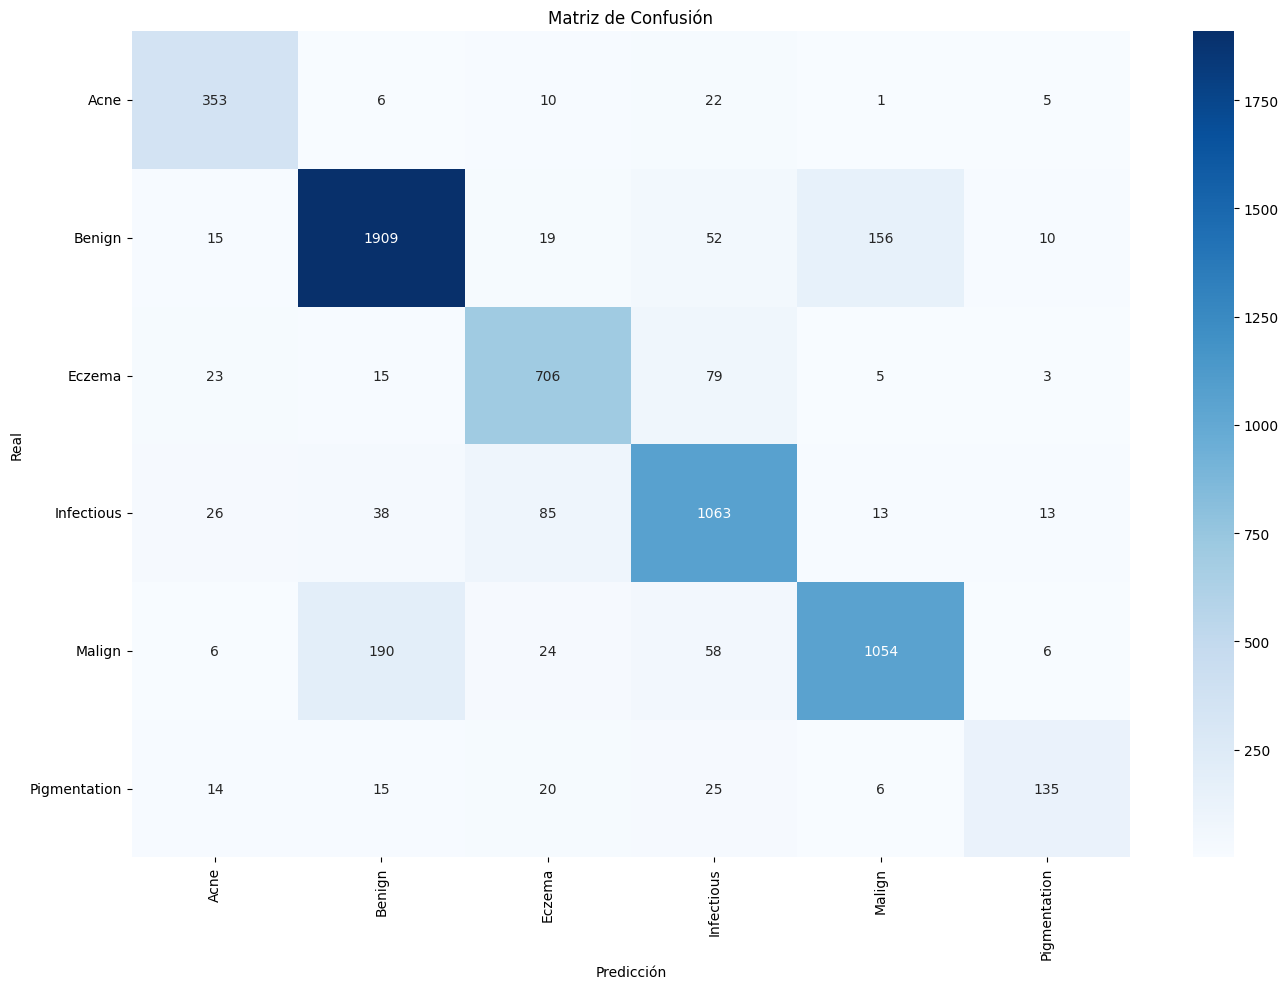

In [14]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
"""
# Rutas
test_dir = '../dataset/multi-6/test'

# Cargar modelo entrenado
model = tf.keras.models.load_model(model_path)

# Cargar dataset de test
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False  # MUY IMPORTANTE para alinear predicciones con etiquetas
)

# Obtener nombres de clase
class_names = test_ds.class_names
num_classes = len(class_names)

# Prefetch para acelerar
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Obtener predicciones
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales
y_true = np.concatenate([y.numpy() for x, y in test_ds])

# Reporte de clasificación
print("🧾 Clasification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

"""
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for x, y in val_ds])

print("\n🧾 Clasification Report (Set de Validación):\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()